В данном блокноте мы научимся работать с библиотекой глубокого обучения Keras. Будем использовать алгоритм , приведенный в https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html, с некоторыми добавлениями и исправлениями.
Наша цель — быстро и просто создать классификатор изображений, используя относительно небольшое (1000) количество обучающих примеров для каждого класса.

Для начала загрузим необходимые библиотеки и создадим необходимые директории.

In [ ]:
!pip install -q tensorflow
!pip install -q keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import os, random, shutil
from PIL import ImageFile
import zipfile
ImageFile.LOAD_TRUNCATED_IMAGES = True


if not os.path.exists('/content/sample_data/test/train/cats/'):
  os.makedirs('/content/sample_data/test/train/cats/')
if not os.path.exists('/content/sample_data/test/train/dogs/'):
  os.makedirs('/content/sample_data/test/train/dogs/')
if not os.path.exists('/content/sample_data/test/preview/'):
  os.makedirs('/content/sample_data/test/preview/')
if not os.path.exists('/content/sample_data/test/validation/сats'):
  os.makedirs('/content/sample_data/test/validation/cats')
if not os.path.exists('/content/sample_data/test/validation/dogs'):
  os.makedirs('/content/sample_data/test/validation/dogs')

Для дальнейших действий необходимо скачать архив с данными с сайта https://www.kaggle.com/c/dogs-vs-cats/data. В нем содержится архив train (изображения , на которых мы будем тренировать и тестировать нашу модель) и архив test1 (изображения, неразделенные по категориям, на которых в самом конце предемонстрируем работу нашей модели).

### Введите сюда свои данные для доступа к API kaggle. Или загрузите необходимые файлы вручную и пропустите этот блок.

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Данные для доступа API
api_token = {"username":"","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 801M/812M [00:06<00:00, 237MB/s]
100% 812M/812M [00:06<00:00, 129MB/s]


In [8]:
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
  zip_ref.extractall(".")

In [9]:
shutil.move("/content/test1.zip", "/content/sample_data/")
shutil.move("/content/train.zip", "/content/sample_data/")

'/content/sample_data/train.zip'

В архиве train.zip находятся изображения кошек и собак. Давайте выберем по 1000 фото для каждого и разархивируем их в соответствующие папки train/dogs/ и train/cats/. Для этого нам понадобится библиотека zipfile.

In [10]:
zip_file = "sample_data/train.zip"
startswith_cats = "cat" # начало имени файла для кошек
startswith_dogs = "dog" # начало имени файла для собак
i = 0 # счетчик для кошек
j = 0 # счетчик для собак
limit = 1000
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    file_new = file.rsplit( "/", 1 )[ 1 ]
    if file_new.startswith(startswith_cats) and i < limit:
      i += 1
      z.extract(file, 'sample_data/test/')
      os.replace('sample_data/test/train/'+file_new,'sample_data/test/train/cats/'+file_new)
    elif file_new.startswith(startswith_dogs) and j < limit:
      j += 1
      z.extract(file,'sample_data/test/')
      os.replace('sample_data/test/train/'+file_new,'sample_data/test/train/dogs/'+file_new)
    elif i >= limit and j >= limit :
      break

Скопируем по 400 файлов, выбранных произвольно, из train/dogs/ и train/cats/ в директории validation/dogs/ и validation/cats/. На тренировочных данных мы будем тренировать нашу модель, а на валидационных тестировать.

In [11]:
old_dir = "sample_data/test/train/"  # старая директория
new_dir = "sample_data/test/validation/"  # новая директория
limit_validation = 400
key_cats = True
key_dogs = True
seed = 1
random.seed(seed) # Зафиксируем зерно, чтобы в валидирующее множество попадали те же изоборажения
while key_cats or key_dogs:
  for label in ['cats','dogs']:
    count = 0
    for f in os.listdir(new_dir+ "/"+ label +"/"):
      if os.path.isfile(os.path.join(new_dir+ "/"+ label +"/", f)):
        count += 1
    if count < limit_validation:
      file_list = os.listdir(old_dir+ "/"+ label +"/")
      file = file_list.pop(random.randint(0, len(file_list)-1))
      shutil.copy(old_dir + "/"+ label +"/" + file, new_dir + "/"+ label +"/" + file)
    else:
      exec('key_%s = False' % label)


Наша задача — обучить модель на сравнительно небольшом количестве исходных данных. Конечно, это количество имеет смысл увеличить с помощью аугментации, т.е. трансформации исходного изображения (изменения масштаба, сдвига, горизонтального отражения).

Давайте для начала рассмотрим аугментацию на примере одного изображения, произвольно выбранного, например, из папки validation/dogs/.

Воспользуемся ImageDataGenerator и командой .flow(). Полученные трансформированные изображения поместим в папку preview/. Во избежании зацикливания генерации, установим лимит, равный 4.


Исходное изображение


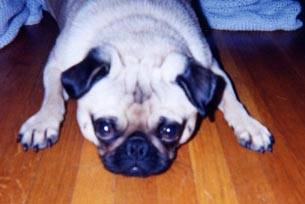

Трансформированные изображения


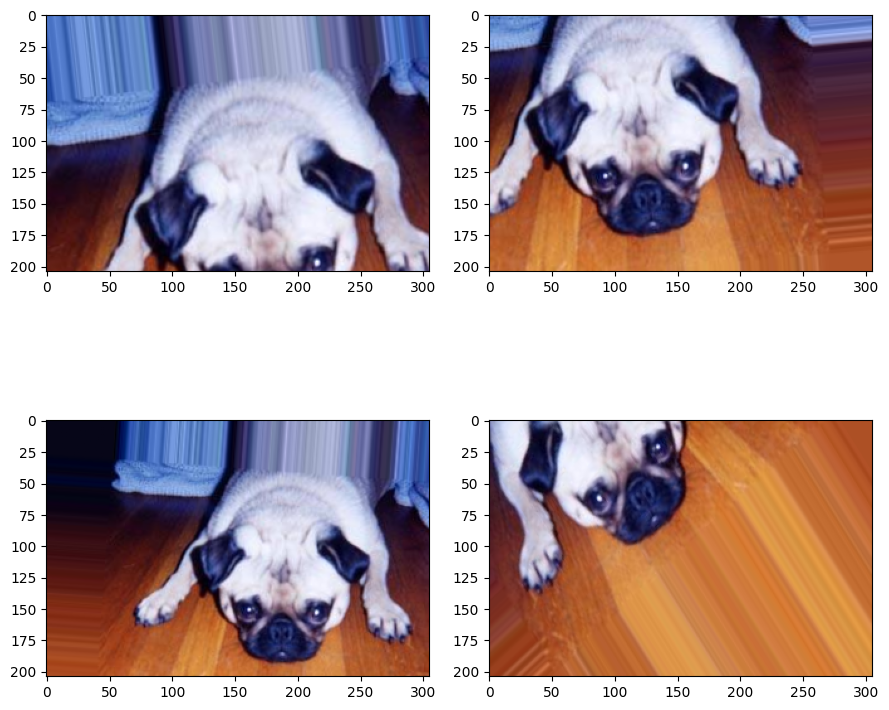

In [12]:
datagen = ImageDataGenerator(
        rotation_range = 40, # диапазон (в градусах), в котором произвольно поворачиваются изображения.
        width_shift_range = 0.2, # это диапазон (доля от общей ширины), в пределах которого можно произвольно менять изображение по вертикали
        height_shift_range = 0.2, # это диапазон (доля от общей высоты), в пределах которого можно произвольно менять изображение или горизонтали
        #rescale=1./255, # значение, на которое умножаем данные перед обработкой. исходное изображение в пространстве RGB имеет значения [0–255], а мы их масшабируем в значения [0-1].
        #rescale не используется в данный момент для того, чтобы полученные изображения можно было посмотреть сразу.
        shear_range = 0.2, # случайное применение сдвиговых преобразований
        zoom_range = 0.2, # случайное увеличение внутри изображения
        horizontal_flip = True, # предназначен для случайного переворачивания половины изображения по горизонтали
        fill_mode = 'nearest') # стратегия, используемая для заполнения вновь созданных пикселей, которые могут появиться после поворота или сдвига ширины/высоты.
dir = 'sample_data/test/validation/dogs/'
random.seed(seed)
img_name = random.choice(os.listdir(dir))
img = load_img(dir + img_name)  # загружаем изображение
print("Исходное изображение")
display(img)
x = img_to_array(img)  # преобразуем в 3-х мерный массив (количество каналов, строки, столбцы)
x = x.reshape((1,) + x.shape)  # преобразуем в 4-х мерный массив (сэмплы, строки, столбцы и каналы).
i = 0
print("Трансформированные изображения")
fig = plt.figure(figsize=(9,9))
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='sample_data/test/preview/', save_prefix='a', save_format='jpeg', seed=seed):
    i += 1
    ax = fig.add_subplot(2, 2, i)
    ax.imshow((batch[0]/255))
    if i >= 4:
        break
fig.tight_layout()
plt.show()

Поскольку у нас сравнительно небольшое количество изображений, мы можем столкнуться с проблемой переобучения, то есть проблемой, когда модель изучает шаблоны, которые не обобщаются на новые данные, то есть когда модель начинает использовать нерелевантные функции для прогнозирования. Например, если у кошки есть бантик, это не означает, что все животные с бантиком - кошки. Чтобы избежать переобучения, необходимо сосредоточиться на наиболее важных функциях, обнаруженных в данных, и они с большей вероятностью будут действительно актуальными и лучше обобщать. Один из способов (именно его будем использовать) это выбор количества слоев и размера каждого слоя.

В нашем случае мы будем использовать очень маленькую свертку с несколькими слоями и несколькими фильтрами на слой, наряду с увеличением и отключением данных. Отключение также помогает уменьшить переообучение, не позволяя слою видеть дважды один и тот же шаблон, тем самым действуя аналогично увеличению данных (и выпадение, и увеличение данных имеют тенденцию нарушать случайные корреляции).

Начнем строить нашу модель. Выберем модель Sequential представляет собой линейный стек слоев. В нашем случае будет три сверточных слоя с активацией ReLU (Rectified Linear Unit) и последующими слоями максимального объединения.

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

img_width, img_height = 150, 150 # ширина, высота изображений

train_data_dir = 'sample_data/test/train' # директория с изображениями кошек и собак для последующего обучения модели
validation_data_dir = 'sample_data/test/validation' # директория с изображениями для тестирования модели
nb_train_samples = 2000 # количество тренировочных изображений
nb_validation_samples = 800 # количество изображений для тестирования
epochs = 30 # количество эпох (итераций)
batch_size = 16 # данные разбиваются на "пакеты" размером "batch_size"

if K.image_data_format() == 'channels_first': # для сохранения упорядочевания весов при переключении модели с одного формата данных на другой
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # добавляем сверточный 2D-слой. Поскольку это 1-ый слой, необходимо задать ключевой аргумент input_shape
# 32 - количество выходных фильтров в свертке, т.е. сколько признаков будем искать
# (3, 3) - kernel_size-высота и ширина окна 2D свертки
# Имеется 32 фильтра, каждый 3x3x3 (т. е. 27 весов), плюс 1 для смещения (т. е. всего 28 весов каждый). 32 фильтра * 28 весов = 896 параметров.
model.add(Activation('relu')) # указываем функцию активации. В данном случае f(z)=max(0,z)
model.add(MaxPooling2D(pool_size=(2, 2))) # уменьшим размер исходной матрицы (этот слой обязателен после сверточных слоев)

model.add(Conv2D(32, (3, 3))) # добавляем второй сверточный слой
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3))) # добавляем третий сверточный слой (размер фильтра увеличивается, так что сеть уже может изучать более сложные представления)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # слой, преобразующий 2D-данные в 1D-данные
model.add(Dense(64)) # добавляем полносвязный слой с указанием числа выходов
model.add(Activation('relu'))
model.add(Dropout(0.5)) # добавляем слой, обнуляющий в модели часть весов, чтоб избежать переобучения (0,5 означает, что он отбрасывает 50% существующих соединений)
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



Посмотреть информацию о скомпилированной модели можно  следующим образом:


In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

или так

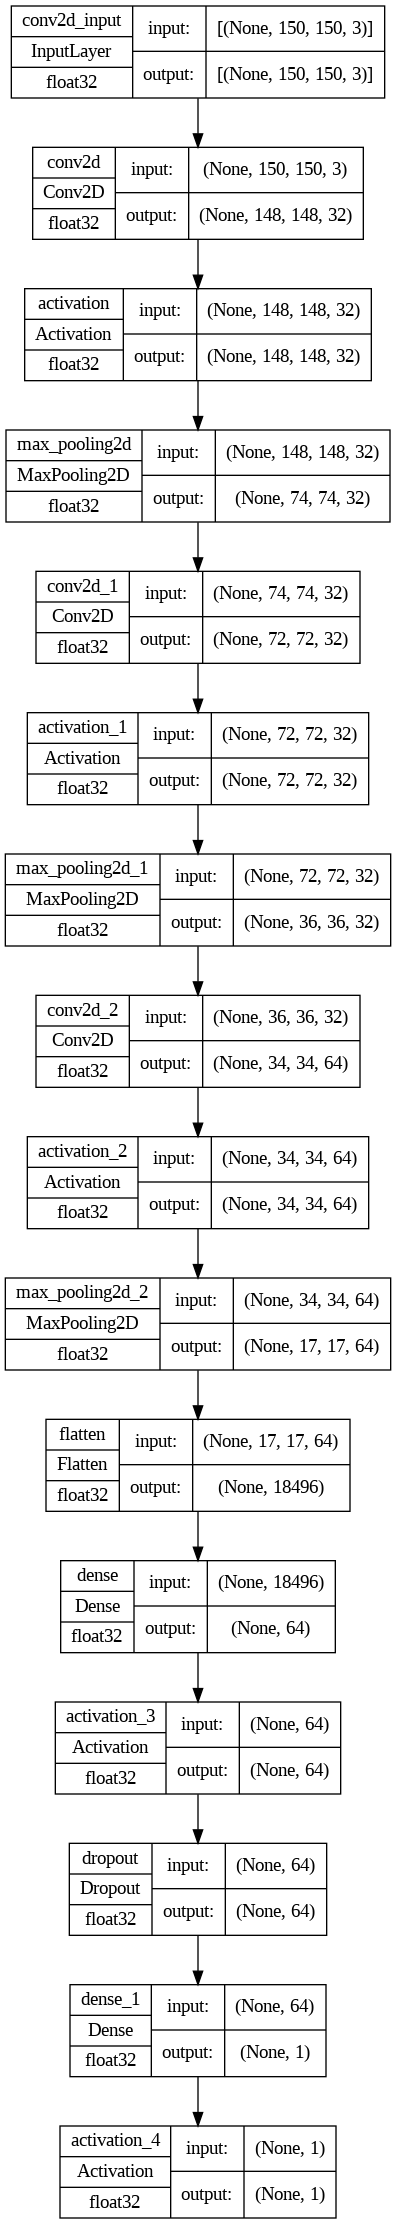

In [15]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,
)

Создадим отдельные генераторы для тренировочных и тестовых изображений:

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed)

Found 2000 images belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed)

Found 800 images belonging to 2 classes.


Когда мы создаем генераторы, важно убедиться, что количество изображений и классов соответсвует нашим ожиданиям. Если нет, например, мы ожидаем 2 класса (собаки и кошки), а выводится "...belonging to 3 classes.", значит есть скрытая папка, которая может появляться в блокноте в результате Drag-and-drop действий, например. Количество папок можно проверить с помощью os.walk и т.п.

Начинаем тренировать модель. На каждую эпоху (итерацию) приходится больше минуты, на выбранные нами 30 эпох приблизительно уйдет 30-40 минут.

Попробуем добиться воспроизводимых результатов, но в конечно счете у вас могут получаться несколько другие значения в силу целого ряда причин (сторонние внутренние ГСПЧ, архитектура процессора, использование GPU и т.д.).

In [18]:
# Зафикисируем значение зерна
seed_value= 0

# 1. Зафиксируем `PYTHONHASHSEED`
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Зафиксируем ГПСЧ python
import random
random.seed(seed_value)

# 3. Зафиксируем ГПСЧ numpy
import numpy as np
np.random.seed(seed_value)

# 4. Зафиксируем ГПСЧ tensorflow
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Настроим глобальную сессию tensorflow
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [19]:
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
model.save_weights('first_try.h5')

Epoch 1/30
125/125 [==============================] - 45s 356ms/step - loss: 0.7415 - accuracy: 0.5230 - val_loss: 0.6907 - val_accuracy: 0.5275
Epoch 2/30
125/125 [==============================] - 44s 353ms/step - loss: 0.6959 - accuracy: 0.5350 - val_loss: 0.6664 - val_accuracy: 0.6225
Epoch 3/30
125/125 [==============================] - 42s 339ms/step - loss: 0.6685 - accuracy: 0.6020 - val_loss: 0.6355 - val_accuracy: 0.6087
Epoch 4/30
125/125 [==============================] - 43s 347ms/step - loss: 0.6410 - accuracy: 0.6445 - val_loss: 0.5896 - val_accuracy: 0.6737
Epoch 5/30
125/125 [==============================] - 44s 347ms/step - loss: 0.6365 - accuracy: 0.6470 - val_loss: 0.5682 - val_accuracy: 0.7225
Epoch 6/30
125/125 [==============================] - 48s 383ms/step - loss: 0.6041 - accuracy: 0.6745 - val_loss: 0.5821 - val_accuracy: 0.6775
Epoch 7/30
125/125 [==============================] - 45s 356ms/step - loss: 0.5992 - accuracy: 0.6805 - val_loss: 0.5042 - val_ac

Из результатов видно, что на тренировочных данных точность порядка 80% (может немного варьироваться).

Теперь посмотрим, как наша модель работает. И делать это будем на изображениях, которые модель еще не видела.

В самом начале в директорию train/ мы скопировали 2000 файлов из архива train.zip. Сейчас сделаем директорию new_files/, в которую накопируем 100 других файлов из train.zip (т.е. их нет в train/ и модель их не видела).


In [20]:
if not os.path.exists('/content/sample_data/test/new_files/cats/'):
  os.makedirs('/content/sample_data/test/new_files/cats/')
if not os.path.exists('/content/sample_data/test/new_files/dogs/'):
  os.makedirs('/content/sample_data/test/new_files/dogs/')
zip_file = "sample_data/train.zip"
startswith_cats = "cat" # начало имени файла для кошек
startswith_dogs = "dog" # начало имени файла для собак
i = 0 # счетчик для кошек
j = 0 # счетчик для собак
limit = 50
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    file_new = file.rsplit( "/", 1 )[ 1 ]
    if file_new.startswith(startswith_cats) and i < limit:
      if not os.path.exists('sample_data/test/train/cats/'+file_new):# проверяем, что файла нет в /train/cats/
        i += 1
        z.extract(file, 'sample_data/test/')
        os.replace('sample_data/test/train/'+file_new,'sample_data/test/new_files/cats/'+file_new)
    elif file_new.startswith(startswith_dogs) and j < limit:
      if not os.path.exists('sample_data/test/train/dogs/'+file_new):# проверяем, что файла нет в /train/dogs/
        j += 1
        z.extract(file,'sample_data/test/')
        os.replace('sample_data/test/train/'+file_new,'sample_data/test/new_files/dogs/'+file_new)
    elif i >= limit and j >= limit :
      break

Создаем новый генератор по образу и подобию валидационного, но в качестве batch_size указываем все 100 изображений.

In [21]:
new_files_dir = 'sample_data/test/new_files/'
new_files_datagen = ImageDataGenerator(rescale=1. / 255)
new_files_generator = new_files_datagen.flow_from_directory(
    new_files_dir,
    target_size=(img_width, img_height),
    batch_size=100,
    class_mode='binary',
    shuffle=False) #Сохраняет последовательноcть файлов из папки

Found 100 images belonging to 2 classes.


Посмотрим на предсказания нашей модели на этом генераторе с помощью model.predict.

In [22]:
imgs,labels=new_files_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
print("Predictions:")
print([x for x in predictions[:5]]) # выводим первые 3 предсказания
rounded_pred=np.asarray([np.round(i) for i in predictions]) #  округляем
print([np.round(x) for x in predictions[:5]])

4/4 [==============================] - 1s 107ms/step
Predictions:
[array([0.67401344], dtype=float32), array([0.35585788], dtype=float32), array([0.00015891], dtype=float32), array([0.2959607], dtype=float32), array([0.43043348], dtype=float32)]
[array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32)]


Предсказания выводятся в виде вещественных чисел от 0 до 1. Кот - 0, собака - 1. Если предсказание меньше 0.5, модель считает, что на фото кот, если больше 0.5, то собака. Чем ближе число к нулю, тем модель больше уверена, что перед ней кот.

Найдем те изображения, для которых наша модель дала неправильные предсказания, т.е. округленное до целого числа предсказание не совпало с ожидаемым. Воспользуемся функцией zip(), которая создает итератор, который объединяет элементы из нескольких источников данных (у нас это будет изображение, предсказание, округленное предсказание и правильный вариант (label)).

In [23]:
list=[item for item in zip(array_imgs, rounded_pred, labels, predictions) if item[1]!=item[2]] # список изображений, для которых предсказание не совпало с реальностью
print("Ошибочных:",len(list))

Ошибочных: 23


Для первых шести ошибочных определений выведем имеющуюся информацию.

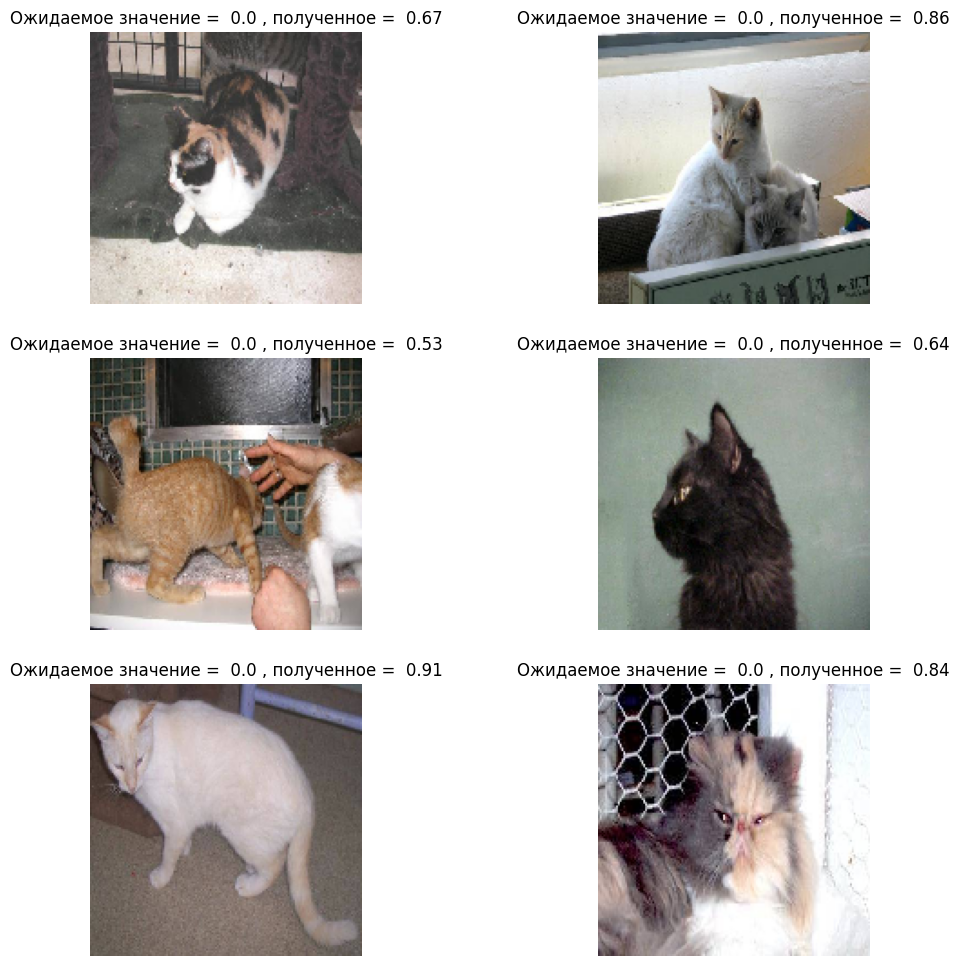

In [24]:
fig = plt.figure(figsize=(12,12))
for ind, item in enumerate(list[:6]):
  img_failed = item[0]
  ax = fig.add_subplot(3,2,ind+1)
  plt.axis('off')
  ax.imshow(np.transpose(img_failed,(1,0,2)))
  ax.set_title('%s %s %s %s' % ("Ожидаемое значение = ",item[2],", полученное = ",np.round(item[3][0], 2)))
fig.tight_layout
plt.show()

Сравним точность нашей модели на валидационных и новых данных.

In [25]:
accuracy = model.evaluate_generator(validation_generator,800 // batch_size)
print("Точность на валидационных данных: %.2f%%" % (accuracy[1]*100))
accuracy = model.evaluate_generator(new_files_generator, 1)
print("Точность на новых данных: %.2f%%" % (accuracy[1]*100))

<ipython-input-25-1ef95b6fce4e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy = model.evaluate_generator(validation_generator,800 // batch_size)


Точность на валидационных данных: 89.88%


<ipython-input-25-1ef95b6fce4e>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy = model.evaluate_generator(new_files_generator, 1)


Точность на новых данных: 77.00%


Эти отличия можно объяснить "переобученностью" модели (у нас грубый отсев Dropout(0.5)), сравнительно небольшим набором валидационных данных и т.п.

В конце попробуем продемонстрировать работу нашей модели на еще одном наборе данных. Разархивируем файлы из архива test1.zip. Тут уже нет деления на котов и собак. Угадает или нет?

В директорию verification/ мы разархивируем 800 файлов, а потом проверим нашу модель на любых четырех из них. Конечно, можно добавить свои изображения кошек, собак.

In [26]:
zip_file = "sample_data/test1.zip"
i = 0 # счетчик
limit_verification = 800
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    if file.endswith("jpg") and i < limit_verification:
      i += 1
      z.extract(file, 'sample_data/test/verification/')
    elif i >= limit_verification:
      break

Сделаем соответствующий генератор и выведем результаты для любых четырех изображений:

Found 800 images belonging to 1 classes.
25/25 [==============================] - 4s 146ms/step


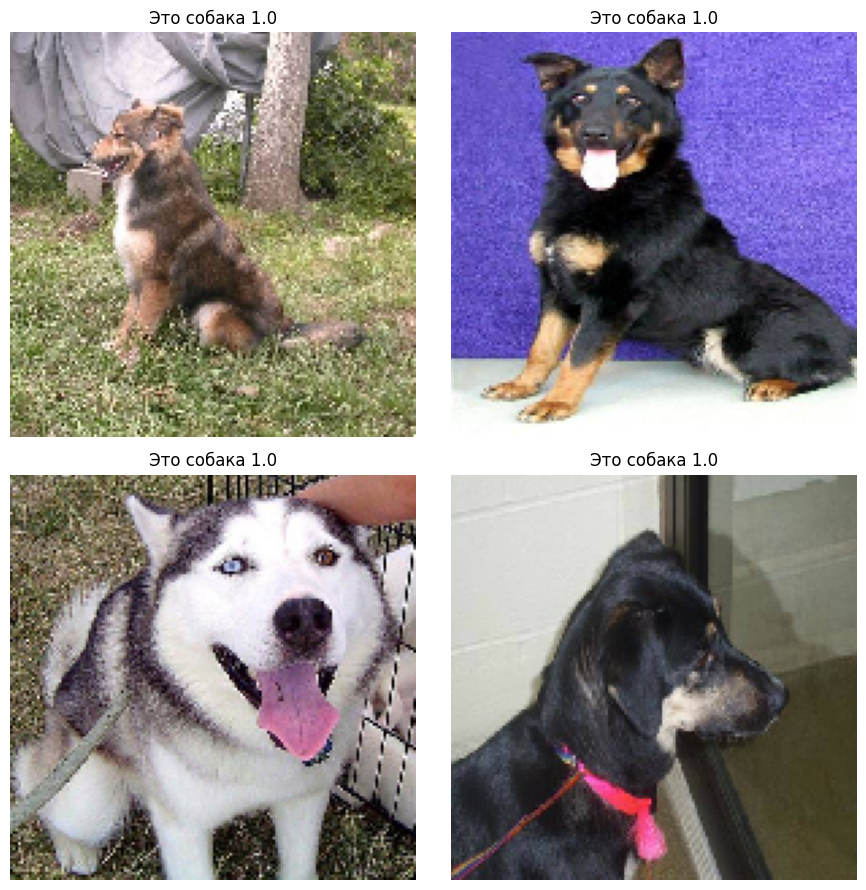

In [27]:
test_dir = 'sample_data/test/verification/'
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=800,
    class_mode='binary')
imgs,labels=test_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])
list1 = [item for item in zip(array_imgs, rounded_pred, labels, predictions)]
fig = plt.figure(figsize=(9,9))
# выведем результат для 4-х любых изображений
for i in range(1,5):
    item = random.choice(list1)
    img = item[0]
    ax = fig.add_subplot(2, 2, i)
    plt.axis('off')
    ax.imshow(np.transpose(img,(1,0,2)))
    if np.round(item[3][0], 2) <= 0.5:
      ax.set_title('%s %s' % ('Это кот',np.round(item[3][0], 2)), fontsize=12)
    else:
      ax.set_title('%s %s' % ('Это собака',np.round(item[3][0])), fontsize=12)
fig.tight_layout()
plt.show()




В блоге https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html приводятся несколько вариантов усовершенствования нашей модели.

Предлагается ознакомится с ними самостоятельно и сравнить результаты.